In [1]:
# Importing standard python libraries
import numpy as np
from math import pi,sqrt
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, QuantumRegister
from qiskit.tools.jupyter import *
from qiskit.visualization import * # plot_bloch_multivector
from ibm_quantum_widgets import *  #CircuitComposer
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector

# Loading your IBM Quantum account(s)
# provider = IBMQ.load_account()

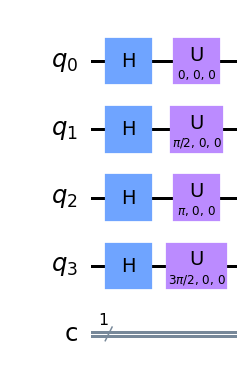

In [2]:
# Start with an one qubit quantum circuit yielding a nice fractal. Change the circuit as you like.
circuit = QuantumCircuit(4,1)
circuit.h(0)
circuit.h(1)
circuit.h(2)
circuit.h(3)
circuit.u(0, 0, 0, 0)
circuit.u(pi/2, 0, 0, 1)
circuit.u(pi, 0, 0, 2)
circuit.u(3*pi/2, 0, 0, 3)
display(circuit.draw(output="mpl", scale=1.5))

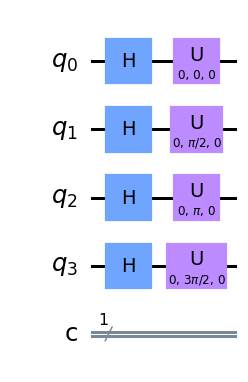

In [3]:
circuit2 = QuantumCircuit(4,1)
circuit2.h(0)
circuit2.h(1)
circuit2.h(2)
circuit2.h(3)
circuit2.u(0, 0, 0, 0)
circuit2.u(0, pi/2, 0, 1)
circuit2.u(0, pi, 0, 2)
circuit2.u(0, 3*pi/2, 0, 3)
display(circuit2.draw(output="mpl", scale=1.5))

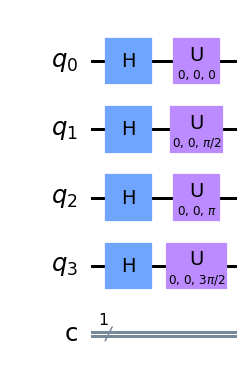

In [4]:
circuit3 = QuantumCircuit(4,1)
circuit3.h(0)
circuit3.h(1)
circuit3.h(2)
circuit3.h(3)
circuit3.u(0, 0, 0, 0)
circuit3.u(0, 0, pi/2, 1)
circuit3.u(0, 0, pi, 2)
circuit3.u(0, 0, 3*pi/2, 3)
display(circuit3.draw(output="mpl", scale=1.5))

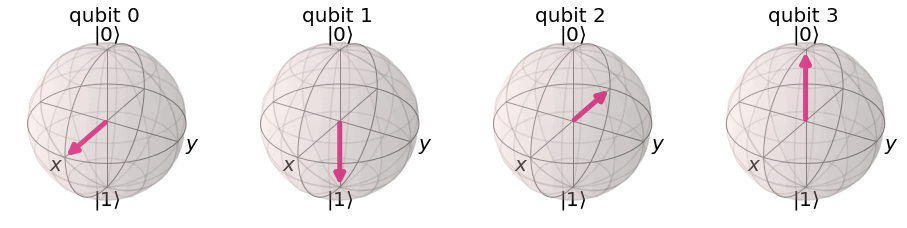

In [5]:
# View the circiut quantum state on the Bloch sphere  for theta
qc1 = circuit
plot_bloch_multivector(qc1)

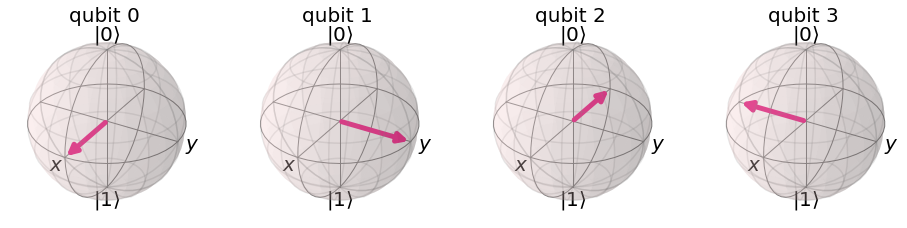

In [6]:
# new circuit's quantum state(s) for phi
qc2 = circuit2
plot_bloch_multivector(qc2)

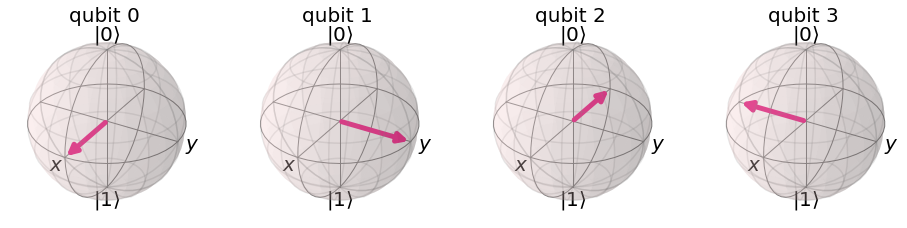

In [7]:
# new circuit's quantum state(s) for lambda
qc3 = circuit3
plot_bloch_multivector(qc3)

z=  (1+0j)


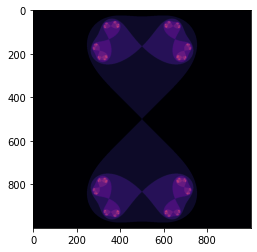

In [8]:
# Run the circuit with the state vector simulator to obtain a noise-free fractal.
backend = Aer.get_backend('statevector_simulator')
out = execute(qc1,backend).result().get_statevector()
#print(out)

# Extract the first element of the state vector as z0 and the second element as z1.
z0 = out.data[0]
z1 = out.data[1]


# Goal: One complex number for the Julia set fractal. 
if z1.real != 0 or z1.imag != 0:
    z = z0/z1
    z = round(z.real, 2) + round(z.imag, 2) * 1j
else:
     z = 0 

print("z= ",z)

# Define the size
size = 1000
heightsize = size
widthsize = size


def julia_set(c=z, height=heightsize, width=widthsize, x=0, y=0, zoom=1, max_iterations=100):

    # To make navigation easier we calculate these values
    x_width = 1.5
    y_height = 1.5*height/width
    x_from = x - x_width/zoom
    x_to = x + x_width/zoom
    y_from = y - y_height/zoom
    y_to = y + y_height/zoom
    
    # Here the actual algorithm starts and the z paramter is defined for the Julia set function
    x = np.linspace(x_from, x_to, width).reshape((1, width))
    y = np.linspace(y_from, y_to, height).reshape((height, 1))
    z = x + 1j * y
    
    # Initialize c to the complex number obtained from the quantum circuit
    c = np.full(z.shape, c)
    
    # To keep track in which iteration the point diverged
    div_time = np.zeros(z.shape, dtype=int)
    
    # To keep track on which points did not converge so far
    m = np.full(c.shape, True, dtype=bool)
    
    for i in range(max_iterations):
        z[m] = z[m]**2 + c[m] 
        m[np.abs(z) > 2] = False
        div_time[m] = i
    return div_time


# plot the Julia set fractal
plt.imshow(julia_set(), cmap='magma') # viridis', 'plasma', 'inferno', 'magma', 'cividis'
plt.show()

# Running on a real quantum computer
### Identify the least busy system, perform measurements and run on the backend

In [9]:
# Find the least busy system that has at least 1 qubit
from qiskit.providers.ibmq import least_busy

ibmq_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 1 and 
                                   not x.configuration().simulator and x.status().operational==True))

print("The least busy quantum computer now is",ibmq_backend)

NameError: name 'provider' is not defined

In [ ]:
# Add measurement - used to calculate the modified state vector
qc1.measure(0, 0)
qc1.draw()

In [ ]:
# Define the number of shots for the execution. 
shotno=1024

# Run the circuit on a real quantum computer. NB! This may take a while.
job_ibmq = execute(qc1, ibmq_backend, shots=shotno)
result = job_ibmq.result()

## Perform calculations and plot result

In [ ]:
# Get count measurement results
counts = result.get_counts()


prob0qc = counts['0']/shotno
prob1qc = counts['1']/shotno
#print("Observed probabilities of measuring the computational basis states", round(prob0qc,3), round(prob1qc,3))

#print("Statevector: ", out)
#print("Statevector probilities of measuring the basis states: ", out.probabilities())
prob0statevec = out.probabilities()[0]
prob1statevec = out.probabilities()[1]

# one simple approach to calculate a quantum computer-modified complex number # amplitude^2 = probability
z0qc = z0*sqrt(prob0qc/prob0statevec)
z1qc = z1*sqrt(prob1qc/prob1statevec)
zqc = z0qc/z1qc
#zqcminus = -z0qc/z1qc
#print(z,zqc,zqcminus)

# compare the simulator state vector with the-running-on-a-real-quantum-computer modified state vector
print(z,zqc)

# Plot both Julia set fractals for comparison - the simulator based on the left and the modified on the right 
f, axarr = plt.subplots(1,2,figsize=(12, 12))
axarr[0].imshow(julia_set(c=z), cmap='magma')
axarr[1].imshow(julia_set(c=zqc), cmap='magma')